# CIFAR10-KERAS-NN

The following script executes a program for picture recognition on the CIFAR-10 dataset using keras neural networks

In [1]:
### Packages
from datetime import datetime
import time
import os

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# https://stackoverflow.com/questions/3899980/how-to-change-the-font-size-on-a-matplotlib-plot
SMALL_SIZE = 16
MEDIUM_SIZE = 20
BIGGER_SIZE = 22
plt.rc('font', size=MEDIUM_SIZE)            # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)        # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)        # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)       # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)       # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)       # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)     # fontsize of the figure title

# Dataset
from keras.datasets import cifar10

# Subroutines
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPooling2D
import keras_tuner as kt
from sklearn.metrics import confusion_matrix

# Additional configurations, @see config.py
import config

### Configurations
# Training-Size
num_train = config.num_train                   # 60000 for full data set 
num_test  = config.num_test                    # 10000 for full data set

2022-09-20 21:13:59.350217: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-20 21:13:59.609737: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-20 21:13:59.609762: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-09-20 21:13:59.646857: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-09-20 21:14:00.331116: W tensorflow/stream_executor/platform/de

In [2]:
# Simple functions to log information
path = os.getcwd()+"/log"
logDir = os.path.exists(path)
if not logDir:
    os.makedirs(path)

plots = os.getcwd()+"/log/plots"
logDir = os.path.exists(plots)
if not logDir:
    os.makedirs(plots)

training_results = path+"/keras-nn-training-log.txt"
def log_training_results(*s):
    with open(training_results, 'a') as f:
        for arg in s:
            print(arg, file=f)
            print(arg)

hyperparameter_search_log = path+"/keras-nn-hyperparameter-tuning-log.txt"
def log_hyperparameter_search(*s):
    with open(hyperparameter_search_log, 'a') as f:
        for arg in s:
            print(arg, file=f)
            print(arg)

print("Generated data will be located in ", training_results, hyperparameter_search_log)
print("Generated plots will be located in ", plots)

log_training_results("[%s] on (%s, %s) using (Train: %s, Test: %s)" % (datetime.now(), config.os, config.cpu, config.num_train, config.num_test))
if config.hyper_parameter_search:
    log_hyperparameter_search("[%s] on (%s, %s) using (Train: %s, Test: %s)" % (datetime.now(), config.os, config.cpu, config.num_train, config.num_test))



Generated data will be located in  /home/thauer/GitProjects/CIFAR10_Benchmark/src/log/keras-nn-training-log.txt /home/thauer/GitProjects/CIFAR10_Benchmark/src/log/keras-nn-hyperparameter-tuning-log.txt
Generated plots will be located in  /home/thauer/GitProjects/CIFAR10_Benchmark/src/log/plots
[2022-09-20 21:14:01.135314] on (Linux-5.15.0-46-generic-x86_64-with-glibc2.29, x86_64) using (Train: 6250, Test: 1250)
[2022-09-20 21:14:01.135570] on (Linux-5.15.0-46-generic-x86_64-with-glibc2.29, x86_64) using (Train: 6250, Test: 1250)


In [3]:
# Fetch CIFAR10-Data from Keras repository
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

In [4]:
print("\t\t\t\t (Sets,  X,  Y, RGB)")
print("Shape of training data:\t\t", X_train.shape)
print("Shape of training labels:\t", y_train.shape)
print("Shape of testing data:\t\t", X_test.shape)
print("Shape of testing labels:\t", y_test.shape)

				 (Sets,  X,  Y, RGB)
Shape of training data:		 (50000, 32, 32, 3)
Shape of training labels:	 (50000, 1)
Shape of testing data:		 (10000, 32, 32, 3)
Shape of testing labels:	 (10000, 1)


/home/thauer/.local/lib/python3.8/site-packages/matplotlib/text.py:1223: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


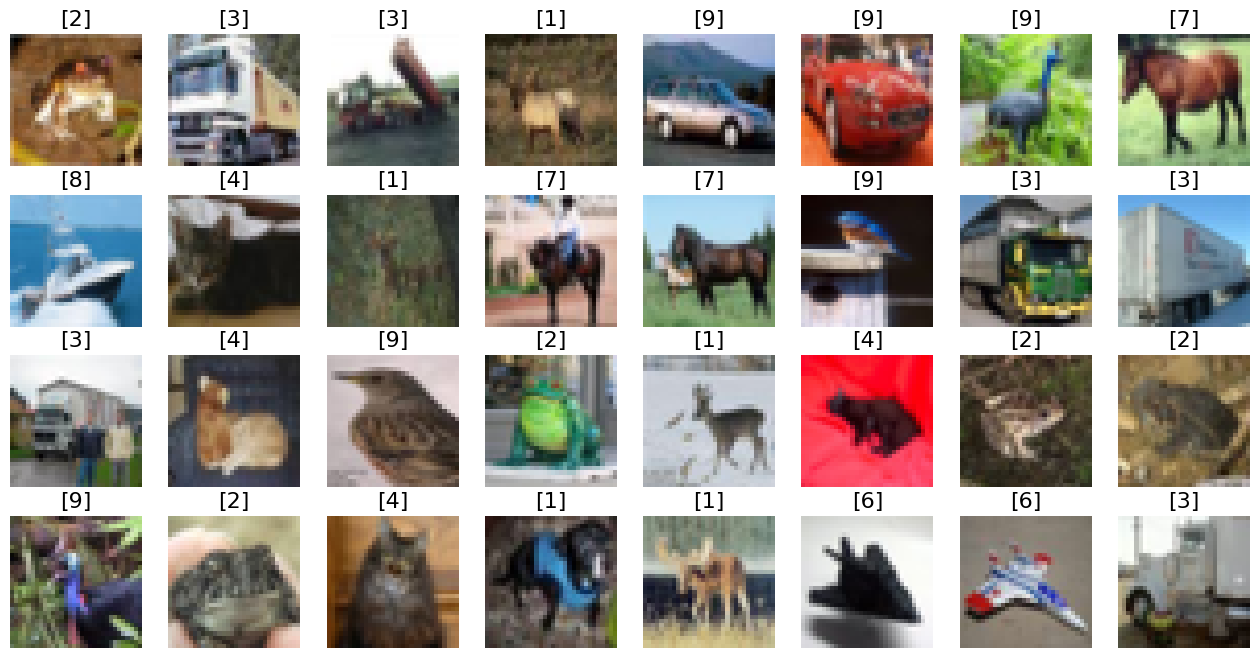

In [5]:
# Visualize some examples
cols=8
rows=4
fig, ax = plt.subplots(ncols=cols, nrows=rows, figsize=(cols*2, rows*2))
index = 0
for i in range(rows):
    for j in range(cols):
        ax[i,j].imshow(X_train[index])
        ax[i,j].set_title(y_train[y_train[index][0]], fontsize=16)
        ax[i,j].imshow(X_train[index])
        ax[i,j].axis('off')
        index += 1
plt.show()
fig.savefig(plots+'/cifar10_examples.png')


In [6]:
train_data = X_train
train_label = y_train
test_data = X_test
test_label = y_test

In [7]:
# Reshape the data such that we have access to every pixel of the image
train_data = X_train.astype('float32')
train_label = y_train.astype("float32")
test_data = X_test.astype('float32')
test_label = y_test.astype("float32")


In [8]:
# We know the RGB color code where different values produce various colors. It is also difficult to remember every color combination. 
# We already know that each pixel has its unique color code and also we know that it has a maximum value of 255. 
# To perform Machine Learning, it is important to convert all the values from 0 to 255 for every pixel to a range of values from 0 to 1.
train_data = train_data / 255
test_data = test_data / 255

In [9]:
# Categorize the labels by conversion from integers to a class matrix
train_label = keras.utils.to_categorical(train_label, config.num_classes)
test_label = keras.utils.to_categorical(test_label, config.num_classes)

In [10]:
# As an optional step, we decrease the training and testing data size, such that the algorithms perform their execution in acceptable time
train_data = train_data[1:num_train,]
train_label = train_label[1:num_train]

test_data = test_data[1:num_test,]
test_label = test_label[1:num_test]

In [11]:
print("\t\t\t\t (Sets,  X, Y, RGB )")
print("Reshaped training data:\t\t", train_data.shape)
print("Reshaped training labels:\t", train_label.shape)
print("Reshaped testing data:\t\t", test_data.shape)
print("Reshaped testing labels:\t", test_label.shape)

				 (Sets,  X, Y, RGB )
Reshaped training data:		 (6249, 32, 32, 3)
Reshaped training labels:	 (6249, 10)
Reshaped testing data:		 (1249, 32, 32, 3)
Reshaped testing labels:	 (1249, 10)


# Sequential Neural Network Model

Groups layers into a Tensorflow-defined neural network and provides interfaces for training and inference.

For more information, see: https://keras.io/api/models/sequential/


In [12]:
### Create model: https://keras.io/guides/sequential_model/
model = Sequential()

### Minimum Model
#model.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=(32,32,3), activation='relu', padding='same')) 
#model.add(Flatten()) 
#model.add(Dense(units=config.num_classes, activation="softmax"))

### Standard model
# First convolutional layer
model.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=(32,32,3), activation='relu', padding='same')) 
# Second convolutional layer
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
# Max pooling layer
model.add(MaxPooling2D(pool_size=(2, 2))) 
model.add(Dropout(0.25)) 
# Flatten input into feature vector and feed into dense layer
model.add(Flatten()) 
model.add(Dense(units=config.num_of_units, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=config.num_of_units, activation='relu'))
model.add(Dropout(0.5))
# Outputs from dense layer are projected onto 10 unit output layer
model.add(Dense(units=config.num_classes, activation="softmax"))

# Compile model
optimizer = keras.optimizers.RMSprop(
    learning_rate=0.0001,
    epsilon = 1e-6,
)

model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 30, 30, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 15, 15, 32)        0         
                                                                 
 flatten (Flatten)           (None, 7200)              0         
                                                                 
 dense (Dense)               (None, 256)               1843456   
                                                        

2022-09-20 21:14:03.222496: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-09-20 21:14:03.222904: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-09-20 21:14:03.222936: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (warmachine): /proc/driver/nvidia/version does not exist
2022-09-20 21:14:03.223824: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [13]:
# Train model
start_time = time.time()
history = model.fit(
    x=train_data, 
    y=train_label, 
    batch_size=config.batch_size, 
    epochs=config.num_epochs, 
    shuffle=True, 
    validation_data=(test_data, test_label))
end_time = time.time() - start_time

params = {"Keras":{"batch_size":config.batch_size, "epochs":config.num_epochs}}
log_training_results("--- [%s] Trained new model: %s in %s seconds ---" % (datetime.now(), params, end_time))

Epoch 1/10
196/196 [==============================] - 6s 27ms/step - loss: 2.2346 - accuracy: 0.1605 - val_loss: 2.0969 - val_accuracy: 0.2850
Epoch 2/10
196/196 [==============================] - 5s 24ms/step - loss: 2.0570 - accuracy: 0.2407 - val_loss: 2.0033 - val_accuracy: 0.2770
Epoch 3/10
196/196 [==============================] - 4s 23ms/step - loss: 1.9407 - accuracy: 0.2812 - val_loss: 1.8307 - val_accuracy: 0.3835
Epoch 4/10
196/196 [==============================] - 4s 22ms/step - loss: 1.8484 - accuracy: 0.3221 - val_loss: 1.7271 - val_accuracy: 0.4187
Epoch 5/10
196/196 [==============================] - 4s 22ms/step - loss: 1.7868 - accuracy: 0.3389 - val_loss: 1.7112 - val_accuracy: 0.4139
Epoch 6/10
196/196 [==============================] - 4s 22ms/step - loss: 1.7132 - accuracy: 0.3689 - val_loss: 1.6322 - val_accuracy: 0.4355
Epoch 7/10
196/196 [==============================] - 4s 22ms/step - loss: 1.6457 - accuracy: 0.3956 - val_loss: 1.5733 - val_accuracy: 0.4548

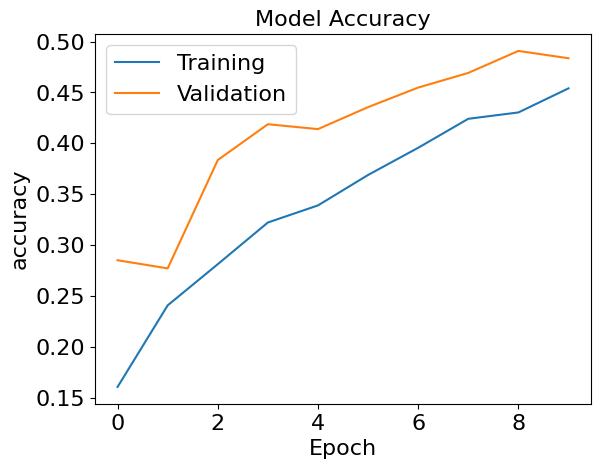

In [14]:
fig = plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()
fig.savefig(plots+'/training_history_standard.png')


In [15]:
# Evaluate model based on supplied tags
start_time = time.time()
test_loss, test_acc = model.evaluate(train_data, train_label)
end_time = time.time() - start_time

log_training_results("\tPredicting train data -- Execution time: %ss; Accuracy: %s; Loss: %s" % (end_time, test_acc, test_loss))  

196/196 [==============================] - 1s 4ms/step - loss: 1.3308 - accuracy: 0.5297
	Predicting train data -- Execution time: 0.8550553321838379s; Accuracy: 0.5296847224235535; Loss: 1.3308467864990234


In [16]:
# Evaluate model based on supplied tags
start_time = time.time()
test_loss, test_acc = model.evaluate(test_data, test_label)
end_time = time.time() - start_time

log_training_results("\tPredicting test data -- Execution time: %ss; Accuracy: %s; Loss: %s" % (end_time, test_acc, test_loss))

40/40 [==============================] - 0s 4ms/step - loss: 1.4649 - accuracy: 0.4836
	Predicting test data -- Execution time: 0.2071971893310547s; Accuracy: 0.4835868775844574; Loss: 1.4648851156234741


In [17]:
# Let model predict data
y_pred = model.predict(test_data)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(test_label, axis=1)

40/40 [==============================] - 0s 4ms/step


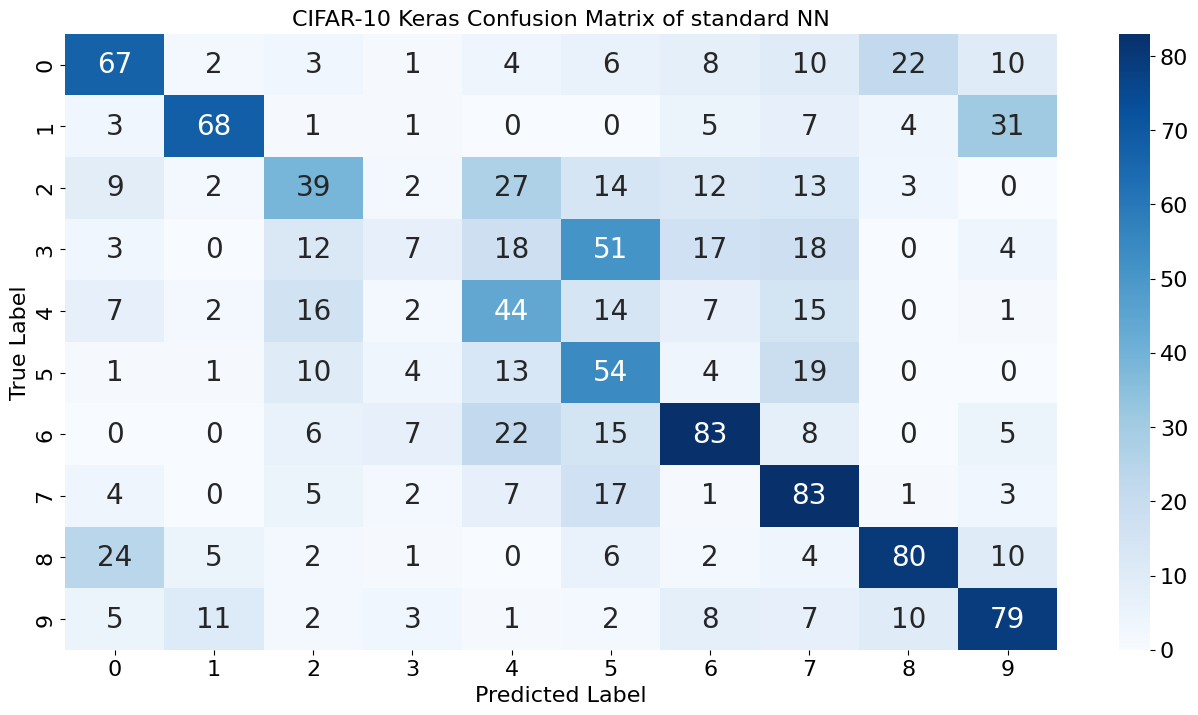

In [18]:
# Visualize estimation over correct and incorrect prediction via confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred_classes)
fig, ax = plt.subplots(figsize=(16,8))
ax = sns.heatmap(confusion_mtx, annot=True, fmt='d', ax=ax, cmap="Blues")
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
ax.set_title('CIFAR-10 Keras Confusion Matrix of standard NN')
plt.show()
fig.savefig(plots+'/ConfusionMatrix_standard.png')

In [19]:
if not config.hyper_parameter_search:
    print("Terminating without hyperparameter search.")
    exit(0)
print("Starting hyperparameter search over %s epochs each" % (config.hps_max_epochs))

Starting hyperparameter search over 20 epochs each


## Hyperparameter evaluation

The search utilizes the keras_tuner library. The model_builder defines the layout and parametrization which are utilized by the different search algorithms further below. 

What can be tuned:
- Dropout: If dropout happens & dropout rate
- Convolutionals: Filters
- Dense: Units
- All: Activation functions

Also see: https://keras.io/api/keras_tuner/

In [20]:
def model_builder(hp):
    # Base Model
    model = keras.Sequential()

    # Hyperparameters
    hp_secondary_conv2d = hp.Boolean("Use 2nd Conv. Layer")
    hp_conv_activations = hp.Choice('Conv2D Activation', ['relu', 'tanh', 'sigmoid'])

    hp_use_maxpooling2d = hp.Boolean("Use MaxPooling2D")

    hp_dropout = hp.Boolean("Use dropout layers")
    hp_dropout_rate = hp.Float('Dropout rate', min_value=0.25, max_value=0.50, step=0.05)

    hp_use_dense = hp.Boolean("Use dense layers")
    hp_dense_units = hp.Int('Dense Units', min_value=32, max_value=512, step=32)
    hp_dense_activations = hp.Choice('Dense Activation', ['relu', 'tanh', 'sigmoid'])

    hp_learning_rate = hp.Choice('Learning rate', [1e-2, 1e-3, 1e-4, 1e-5])
    
    # First convolutional layer
    model.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=(32,32,3), activation=hp_conv_activations, padding='same')) # Usually RELU

    # Second convolutional layer
    if hp_secondary_conv2d:
        model.add(Conv2D(filters=32, kernel_size=(3, 3), activation=hp_conv_activations)) # Usually RELU

    # Max pooling layer
    if hp_use_maxpooling2d:
        model.add(MaxPooling2D(pool_size=(2, 2))) 

    if hp_dropout:
        model.add(Dropout(rate=hp_dropout_rate))

    # Flatten input into feature vector and feed into dense layer
    model.add(Flatten()) 
    
    if hp_use_dense:
        model.add(Dense(units=hp_dense_units, activation=hp_dense_activations))

    if hp_dropout:
        model.add(Dropout(rate=hp_dropout_rate))
        
    #model.add(Dense(units=config.num_of_units, activation='relu'))
    if hp_use_dense:
        model.add(Dense(units=hp_dense_units, activation=hp_dense_activations))

    if hp_dropout:
        model.add(Dropout(rate=hp_dropout_rate))
    
    # Outputs from dense layer are projected onto 10 unit output layer
    model.add(Dense(units=config.num_classes, activation=hp_dense_activations)) # Usually softmax

    # Compile model
    optimizer = keras.optimizers.RMSprop(
        learning_rate=hp_learning_rate,
        epsilon = 1e-6,
    )

    #model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    return model

### Random Search

See: https://keras.io/api/keras_tuner/tuners/random/

In [21]:
tuner = kt.RandomSearch(
    model_builder,
    objective='val_accuracy',
    #max_epochs=config.max_trials,
    #factor=3,                    
    directory='log/hps',
    project_name='keras-hyperparameter-search-RandomSearch'
)

In [22]:
stop_early = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3, verbose=1)
csvlogger = keras.callbacks.CSVLogger(hyperparameter_search_log, separator=",", append=True)
tuner.search(
    train_data,
    train_label,
    epochs=config.hps_max_epochs,
    validation_split=0.2,
    callbacks=[stop_early]
)

log_hyperparameter_search("--- [%s] Running Parameter-Tests [Keras-RandomSearch] ---" % datetime.now())
best_hps_rs = tuner.get_best_hyperparameters(num_trials=1)[0]
log_hyperparameter_search("Best parameters set found on following development set: %s" % best_hps_rs.values)
best_hps_rs_results = tuner.results_summary(num_trials=1)
best_hps_rs_model = tuner.get_best_models(num_models=1)[0]
rs_test_loss, rs_test_acc = best_hps_rs_model.evaluate(test_data, test_label)
log_hyperparameter_search("\tPredicting test data -- Accuracy: %s; Loss: %s" % (rs_test_acc, rs_test_loss))  

Trial 10 Complete [00h 00m 11s]
val_accuracy: 0.10239999741315842

Best val_accuracy So Far: 0.42719998955726624
Total elapsed time: 00h 03m 23s
INFO:tensorflow:Oracle triggered exit
--- [2022-09-20 21:18:14.553977] Running Parameter-Tests [Keras-RandomSearch] ---
Best parameters set found on following development set: {'Use 2nd Conv. Layer': False, 'Conv2D Activation': 'tanh', 'Use MaxPooling2D': True, 'Use dropout layers': True, 'Dropout rate': 0.39999999999999997, 'Use dense layers': False, 'Dense Units': 128, 'Dense Activation': 'sigmoid', 'Learning rate': 0.0001}
Results summary
Results in log/hps/keras-hyperparameter-search-RandomSearch
Showing 1 best trials
Trial summary
Hyperparameters:
Use 2nd Conv. Layer: False
Conv2D Activation: tanh
Use MaxPooling2D: True
Use dropout layers: True
Dropout rate: 0.39999999999999997
Use dense layers: False
Dense Units: 128
Dense Activation: sigmoid
Learning rate: 0.0001
Score: 0.42719998955726624
40/40 [==============================] - 0s 2ms

In [23]:
top3_hps = tuner.get_best_hyperparameters(3)
top3_models = tuner.get_best_models(3)
for i in range(1, 3):
    log_hyperparameter_search("Additional parameters set found on following development set: %s" % top3_hps[i].values)
    loss, acc = top3_models[i].evaluate(test_data, test_label)
    log_hyperparameter_search("\tPredicting test data -- Accuracy: %s; Loss: %s" % (acc, loss))  

Additional parameters set found on following development set: {'Use 2nd Conv. Layer': False, 'Conv2D Activation': 'relu', 'Use MaxPooling2D': True, 'Use dropout layers': False, 'Dropout rate': 0.44999999999999996, 'Use dense layers': True, 'Dense Units': 288, 'Dense Activation': 'relu', 'Learning rate': 0.001}
40/40 [==============================] - 0s 3ms/step - loss: 4.3466 - accuracy: 0.3563
	Predicting test data -- Accuracy: 0.356285035610199; Loss: 4.346632957458496
Additional parameters set found on following development set: {'Use 2nd Conv. Layer': False, 'Conv2D Activation': 'tanh', 'Use MaxPooling2D': True, 'Use dropout layers': False, 'Dropout rate': 0.35, 'Use dense layers': True, 'Dense Units': 480, 'Dense Activation': 'sigmoid', 'Learning rate': 1e-05}
40/40 [==============================] - 0s 3ms/step - loss: 1.9961 - accuracy: 0.3403
	Predicting test data -- Accuracy: 0.3402722179889679; Loss: 1.996132493019104


### Bayesian Optimiziation

See: https://keras.io/api/keras_tuner/tuners/bayesian/

In [24]:
tuner = kt.BayesianOptimization(
    model_builder,
    objective='val_accuracy',
    max_trials=config.hps_max_trials,
    #factor=3,                    
    directory='log/hps',
    project_name='keras-hyperparameter-search-BayesianOptimization'
)

In [25]:
stop_early = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3, verbose=1)
csvlogger = keras.callbacks.CSVLogger(hyperparameter_search_log, separator=",", append=True)
tuner.search(
    train_data,
    train_label,
    epochs=config.hps_max_epochs,
    validation_split=0.2,
    callbacks=[stop_early]
)

log_hyperparameter_search("--- [%s] Running Parameter-Tests [Keras-BayesianOptimization] ---" % datetime.now())
best_hps_bo = tuner.get_best_hyperparameters(num_trials=1)[0]
log_hyperparameter_search("Best parameters set found on following development set: %s" % best_hps_bo.values)

best_hps_bo_results = tuner.results_summary(num_trials=1)

best_hps_bo_model = tuner.get_best_models(num_models=1)[0]
bo_test_loss, bo_test_acc = best_hps_bo_model.evaluate(test_data, test_label)
log_hyperparameter_search("\tPredicting test data -- Accuracy: %s; Loss: %s" % (bo_test_acc, bo_test_loss))  

Trial 15 Complete [00h 00m 07s]
val_accuracy: 0.19920000433921814

Best val_accuracy So Far: 0.2800000011920929
Total elapsed time: 00h 02m 05s
INFO:tensorflow:Oracle triggered exit
--- [2022-09-20 21:20:21.357372] Running Parameter-Tests [Keras-BayesianOptimization] ---
Best parameters set found on following development set: {'Use 2nd Conv. Layer': False, 'Conv2D Activation': 'relu', 'Use MaxPooling2D': True, 'Use dropout layers': False, 'Dropout rate': 0.25, 'Use dense layers': False, 'Dense Units': 32, 'Dense Activation': 'relu', 'Learning rate': 0.01}
Results summary
Results in log/hps/keras-hyperparameter-search-BayesianOptimization
Showing 1 best trials
Trial summary
Hyperparameters:
Use 2nd Conv. Layer: False
Conv2D Activation: relu
Use MaxPooling2D: True
Use dropout layers: False
Dropout rate: 0.25
Use dense layers: False
Dense Units: 32
Dense Activation: relu
Learning rate: 0.01
Score: 0.2800000011920929
40/40 [==============================] - 0s 2ms/step - loss: 6.0242 - acc

In [26]:
top3_hps = tuner.get_best_hyperparameters(3)
top3_models = tuner.get_best_models(3)
for i in range(1, 3):
    log_hyperparameter_search("Additional parameters set found on following development set: %s" % top3_hps[i].values)
    loss, acc = top3_models[i].evaluate(test_data, test_label)
    log_hyperparameter_search("\tPredicting test data -- Accuracy: %s; Loss: %s" % (acc, loss))  

Additional parameters set found on following development set: {'Use 2nd Conv. Layer': False, 'Conv2D Activation': 'relu', 'Use MaxPooling2D': True, 'Use dropout layers': False, 'Dropout rate': 0.35, 'Use dense layers': False, 'Dense Units': 384, 'Dense Activation': 'relu', 'Learning rate': 0.01}
40/40 [==============================] - 0s 2ms/step - loss: 7.6242 - accuracy: 0.2442
	Predicting test data -- Accuracy: 0.244195356965065; Loss: 7.624220371246338
Additional parameters set found on following development set: {'Use 2nd Conv. Layer': False, 'Conv2D Activation': 'relu', 'Use MaxPooling2D': True, 'Use dropout layers': False, 'Dropout rate': 0.35, 'Use dense layers': False, 'Dense Units': 288, 'Dense Activation': 'relu', 'Learning rate': 0.01}
40/40 [==============================] - 0s 2ms/step - loss: 9.1341 - accuracy: 0.2226
	Predicting test data -- Accuracy: 0.22257806360721588; Loss: 9.134050369262695


#### Hyperband

See: https://keras.io/api/keras_tuner/tuners/hyperband/


In [27]:
tuner = kt.Hyperband(
    model_builder,
    objective='val_accuracy',
    max_epochs=config.hps_max_trials,
    factor=3,                    
    directory='log/hps',
    project_name='keras-hyperparameter-search-Hyperband'
)


In [28]:
stop_early = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3, verbose=1)
csvlogger = keras.callbacks.CSVLogger(hyperparameter_search_log, separator=",", append=True)
tuner.search(
    train_data,
    train_label,
    epochs=config.hps_max_epochs,
    validation_split=0.2,
    callbacks=[stop_early]
)

log_hyperparameter_search("--- [%s] Running Parameter-Tests [Keras-Hyperband] ---" % datetime.now())
best_hps_hb = tuner.get_best_hyperparameters(num_trials=1)[0]
log_hyperparameter_search("Best parameters set found on following development set: %s" % best_hps_hb.values)

best_hps_hb_results = tuner.results_summary(num_trials=1)

best_hps_hb_model = tuner.get_best_models(num_models=1)[0]
hb_test_loss, hb_test_acc = best_hps_hb_model.evaluate(test_data, test_label)
log_hyperparameter_search("\tPredicting test data -- Accuracy: %s; Loss: %s" % (hb_test_acc, hb_test_loss))  

Trial 30 Complete [00h 00m 13s]
val_accuracy: 0.10239999741315842

Best val_accuracy So Far: 0.48159998655319214
Total elapsed time: 00h 10m 00s
INFO:tensorflow:Oracle triggered exit
--- [2022-09-20 21:30:22.821327] Running Parameter-Tests [Keras-Hyperband] ---
Best parameters set found on following development set: {'Use 2nd Conv. Layer': True, 'Conv2D Activation': 'relu', 'Use MaxPooling2D': False, 'Use dropout layers': False, 'Dropout rate': 0.44999999999999996, 'Use dense layers': True, 'Dense Units': 480, 'Dense Activation': 'sigmoid', 'Learning rate': 0.001, 'tuner/epochs': 15, 'tuner/initial_epoch': 5, 'tuner/bracket': 2, 'tuner/round': 2, 'tuner/trial_id': '0012'}
Results summary
Results in log/hps/keras-hyperparameter-search-Hyperband
Showing 1 best trials
Trial summary
Hyperparameters:
Use 2nd Conv. Layer: True
Conv2D Activation: relu
Use MaxPooling2D: False
Use dropout layers: False
Dropout rate: 0.44999999999999996
Use dense layers: True
Dense Units: 480
Dense Activation: s

In [29]:
top3_hps = tuner.get_best_hyperparameters(3)
top3_models = tuner.get_best_models(3)
for i in range(1, 3):
    log_hyperparameter_search("Additional parameters set found on following development set: %s" % top3_hps[i].values)
    loss, acc = top3_models[i].evaluate(test_data, test_label)
    log_hyperparameter_search("\tPredicting test data -- Accuracy: %s; Loss: %s" % (acc, loss))  

Additional parameters set found on following development set: {'Use 2nd Conv. Layer': True, 'Conv2D Activation': 'tanh', 'Use MaxPooling2D': True, 'Use dropout layers': False, 'Dropout rate': 0.3, 'Use dense layers': False, 'Dense Units': 32, 'Dense Activation': 'sigmoid', 'Learning rate': 0.001, 'tuner/epochs': 15, 'tuner/initial_epoch': 5, 'tuner/bracket': 1, 'tuner/round': 1, 'tuner/trial_id': '0022'}
40/40 [==============================] - 0s 3ms/step - loss: 1.6475 - accuracy: 0.5260
	Predicting test data -- Accuracy: 0.5260208249092102; Loss: 1.647507667541504
Additional parameters set found on following development set: {'Use 2nd Conv. Layer': True, 'Conv2D Activation': 'tanh', 'Use MaxPooling2D': True, 'Use dropout layers': False, 'Dropout rate': 0.3, 'Use dense layers': False, 'Dense Units': 32, 'Dense Activation': 'sigmoid', 'Learning rate': 0.001, 'tuner/epochs': 5, 'tuner/initial_epoch': 0, 'tuner/bracket': 1, 'tuner/round': 0}
40/40 [==============================] - 0s 3

## Hyperparameter search analytics

Now utilize the 'best' algorithm (weight based on accuracy) and train a new model with the most optimal parameters.

In [30]:
# Map and print the scores
accuracy_score = {"RandomSearch": rs_test_acc, "BayesianOptimization": bo_test_acc, "HyperBand": hb_test_acc}
loss_score = {"RandomSearch": rs_test_loss, "BayesianOptimization": bo_test_loss, "HyperBand": hb_test_loss}

print("--- Finalized scores ")
print("\tAccuracy: %s" % accuracy_score)
print("\tLoss: %s" % loss_score)

--- Finalized scores 
	Accuracy: {'RandomSearch': 0.40512409806251526, 'BayesianOptimization': 0.3010408282279968, 'HyperBand': 0.5252201557159424}
	Loss: {'RandomSearch': 1.7340798377990723, 'BayesianOptimization': 6.0242438316345215, 'HyperBand': 1.8868718147277832}


In [31]:
# Choose the best model out of all three based on accuracy
# For Loss, it is required to adjust the score here and the values taken for the diagrams below.
# Tip: Search ''accuracy'' and replace
best_accuracy = max(accuracy_score, key=accuracy_score.get)
print("Algorithm: %s" % best_accuracy)

best_accuracy_value = max(accuracy_score.values())
print("Score: %s" % best_accuracy_value)

model = 0
if best_accuracy == "RandomSearch":
    model = tuner.hypermodel.build(best_hps_rs)
elif best_accuracy == "BayesianOptimization":
    model = tuner.hypermodel.build(best_hps_bo)
elif best_accuracy == "HyperBand":
    model = tuner.hypermodel.build(best_hps_hb)


Algorithm: HyperBand
Score: 0.5252201557159424


### Optimal Model Fitting

Train the most-optimal model the algorithm could come up with.

In [32]:
# Train a new model with the optimal algorithm and parameters
start_time = time.time()
history = model.fit(
    x=train_data, 
    y=train_label, 
    batch_size=config.batch_size, 
    epochs=config.num_epochs, 
    shuffle=True, 
    validation_data=(test_data, test_label)
)
end_time = time.time() - start_time
params = {"HPS-Opt-Keras":{"batch_size":config.batch_size, "epochs":config.num_epochs}}
log_training_results("--- [%s] Trained new model: %s in %s seconds ---" % (datetime.now(), params, end_time))

Epoch 1/10
196/196 [==============================] - 15s 76ms/step - loss: 1.9742 - accuracy: 0.2757 - val_loss: 2.1614 - val_accuracy: 0.2618
Epoch 2/10
196/196 [==============================] - 15s 76ms/step - loss: 1.5366 - accuracy: 0.4349 - val_loss: 2.0979 - val_accuracy: 0.2882
Epoch 3/10
196/196 [==============================] - 15s 76ms/step - loss: 1.2709 - accuracy: 0.5425 - val_loss: 1.5435 - val_accuracy: 0.4652
Epoch 4/10
196/196 [==============================] - 15s 76ms/step - loss: 1.0075 - accuracy: 0.6454 - val_loss: 1.5525 - val_accuracy: 0.4892
Epoch 5/10
196/196 [==============================] - 15s 75ms/step - loss: 0.7298 - accuracy: 0.7480 - val_loss: 1.6010 - val_accuracy: 0.4828
Epoch 6/10
196/196 [==============================] - 15s 76ms/step - loss: 0.4585 - accuracy: 0.8497 - val_loss: 1.8683 - val_accuracy: 0.4788
Epoch 7/10
196/196 [==============================] - 15s 76ms/step - loss: 0.2574 - accuracy: 0.9214 - val_loss: 1.8914 - val_accuracy:

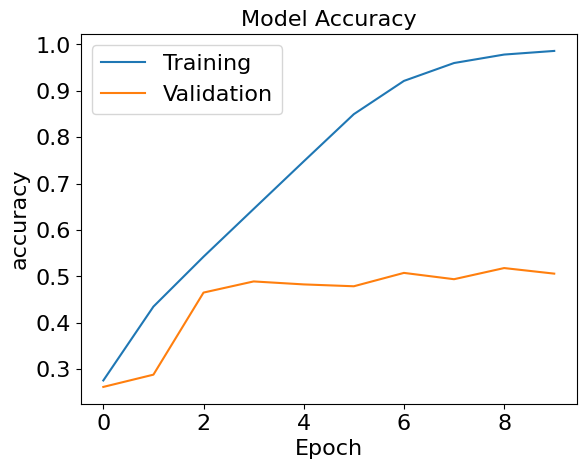

In [33]:
# Display Accuracy
fig = plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()
fig.savefig(plots+'/training_history_optimal.png')

# When a machine learning model has high training accuracy and very low validation then this case is probably known as over-fitting. The reasons for this can be as follows:
#    The hypothesis function you are using is too complex that your model perfectly fits the training data but fails to do on test/validation data.
#    The number of learning parameters in your model is way too big that instead of generalizing the examples , your model learns those examples and hence the model performs badly on test/validation data.

In [34]:
start_time = time.time()
test_loss, test_acc = model.evaluate(train_data, train_label)
end_time = time.time() - start_time
log_training_results("\tPredicting train data -- Execution time: %ss; Accuracy: %s; Loss: %s" % (end_time, test_acc, test_loss))  

196/196 [==============================] - 1s 7ms/step - loss: 0.0258 - accuracy: 0.9922
	Predicting train data -- Execution time: 1.5148465633392334s; Accuracy: 0.9921587705612183; Loss: 0.025836320593953133


In [35]:
# Evaluate model based on supplied tags
start_time = time.time()
test_loss, test_acc = model.evaluate(test_data, test_label)
end_time = time.time() - start_time

log_training_results("\tPredicting test data -- Execution time: %ss; Accuracy: %s; Loss: %s" % (end_time, test_acc, test_loss))  

40/40 [==============================] - 0s 7ms/step - loss: 2.7239 - accuracy: 0.5060
	Predicting test data -- Execution time: 0.34165453910827637s; Accuracy: 0.506004810333252; Loss: 2.7239203453063965


In [36]:
# Let model predict data
y_pred = model.predict(test_data)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(test_label, axis=1)

40/40 [==============================] - 0s 7ms/step


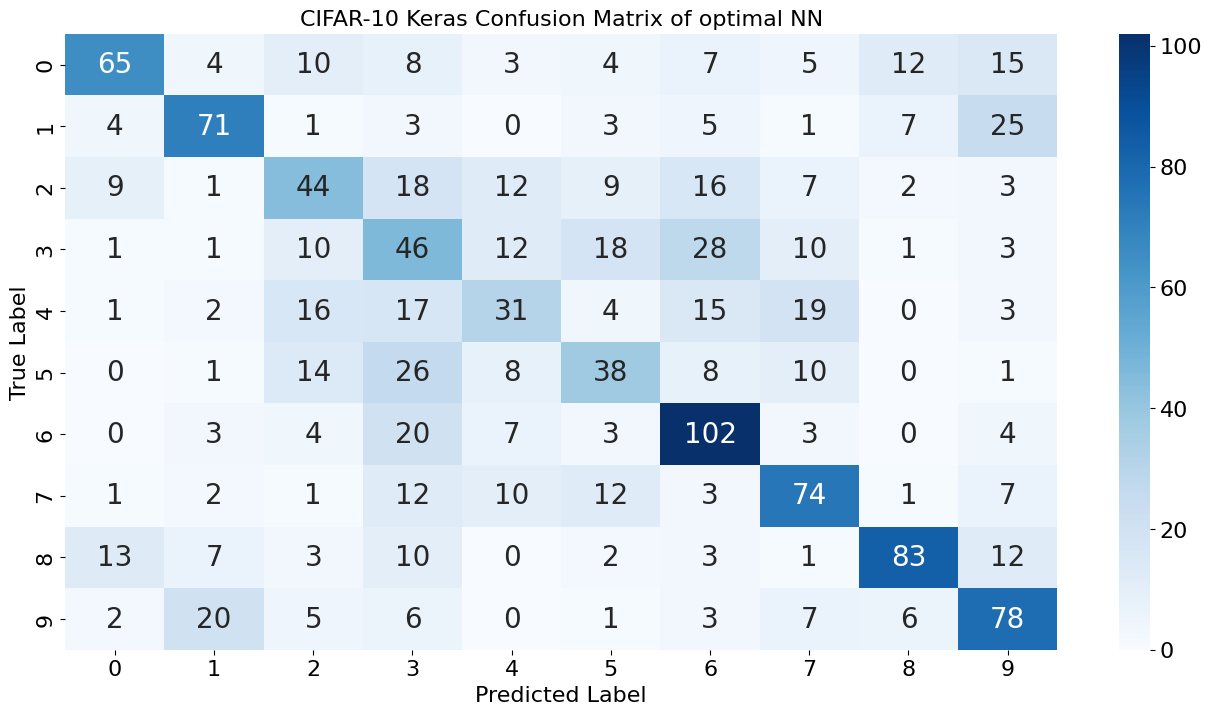

In [37]:
# Visualize estimation over correct and incorrect prediction via confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred_classes)
fig, ax = plt.subplots(figsize=(16,8))
ax = sns.heatmap(confusion_mtx, annot=True, fmt='d', ax=ax, cmap="Blues")
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
ax.set_title('CIFAR-10 Keras Confusion Matrix of optimal NN')
plt.show()
fig.savefig(plots+'/ConfusionMatrix_optimal.png')